# **Preentation Model IA**

## **Import la dataset**

In [266]:
# Importation des bibliothèques nécessaires
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
)
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from google.colab import files
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Configuration pour l'affichage inline des graphiques
%matplotlib inline


In [267]:
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Model AI/mail_data.csv'

# Chemin vers le fichier
df = pd.read_csv(dataset_path)
df1 = pd.read_csv(dataset_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Category,Message,Date,Location
0,ham,"Go until jurong point, crazy.. Available only ...",21/5/2000,Paris
1,ham,Ok lar... Joking wif u oni...,22/5/2000,Paris
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,23/5/2000,Paris
3,ham,U dun say so early hor... U c already then say...,24/5/2000,Paris
4,ham,"Nah I don't think he goes to usf, he lives aro...",25/5/2000,Paris


## **Data Cleaning**

On a besoin que des colone Category et Message, donc c'est mieux de les supprimer de notre dataframe

In [268]:
df.drop( ['Date','Location'],axis=1, inplace=True)

Verification de la suppression des colones

In [269]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Print shape of dataset

In [270]:
df.shape

(5572, 2)

### Renaming required columns

In [271]:
df.rename(
    columns= {
        'Message': 'sms',
        'Category': 'result'
    },
    inplace=True
)

In [272]:
df.head(n=5)

,result,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### info for the dataset to check if null values are present in any of the rows

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   result  5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


There is no null value for any row so no need to remove null values

In [274]:
df.isnull().count()

,0
result,5572
sms,5572


### Check for duplicate rows

In [275]:
df.duplicated().sum()

415

### Remove duplicate datapoints

In [276]:
df.drop_duplicates(keep='first', inplace=True)

### Print number of duplicate rows after removing duplicates

In [277]:
df.duplicated().sum()

0

### Print shape of dataset after removing duplicates

In [278]:
df.shape

(5157, 2)

## **Data Preprocessing**

### Converting result column in numerical binary data

In [279]:
for i in range(df.shape[0]):
    if 'ham' in df['result'].iloc[i]:
        df['result'].iloc[i] = 0
    else:
        df['result'].iloc[i] = 1

<ipython-input-279-46d0eaae2f24>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['result'].iloc[i] = 0
<ipython-input-279-46d0eaae2f24>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values

Verification de la convention de la colone result

In [280]:
class_freq = df['result'].value_counts()
class_freq

,count
result,
0,4516
1,641


In [281]:
print(df['result'].value_counts().index)
print(df['result'].value_counts().values)

Index([0, 1], dtype='object', name='result')
[4516  641]


### plot la fréquence des classes binaires de sortie

<BarContainer object of 2 artists>

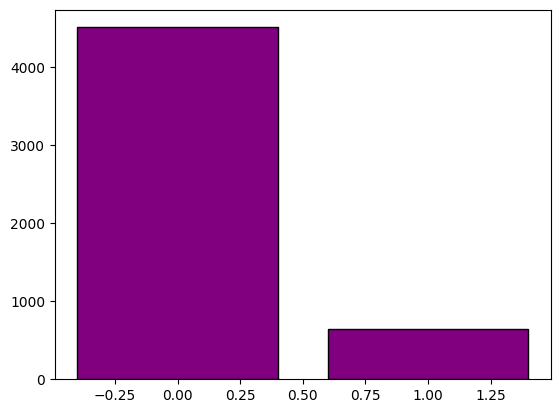

In [282]:
plt.bar(class_freq.index, class_freq.values, color='purple', edgecolor='black')

### supprimer les caractères spéciaux et convertir les points de données en minuscules à partir du dataframe

In [283]:
_index = 0
for row_sms in df['sms']:
    text = ''
    for sms_char in row_sms:
        if sms_char.isalnum() or sms_char.isspace():
            text += sms_char
    df['sms'].iloc[_index] = text.lower()
    _index = _index + 1
    text = ''

<ipython-input-283-e190ba15bd1a>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['sms'].iloc[_index] = text.lower()



### suppression des mots vides des SMS et réduction des radicaux pour une meilleure précision
```
# This is formatted as code
```



In [284]:
#Initialize PorterStemmer object for further stemming of words for text pre-processing
stemmer = PorterStemmer()
nltk.download('stopwords')

_index = 0
for i in range(df.shape[0]):
    split_words = []
    for _word in df['sms'].iloc[i].split():
        if _word not in stopwords.words('english'):
            split_words.append(stemmer.stem(_word))
    df['sms'].iloc[_index] = split_words[:]
    _index = _index + 1
    split_words.clear()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-284-94ab2f943726>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['sms'].iloc[_index] = split_words[:]

### joindre des messages SMS ensemble après le prétraitement du texte

In [285]:
for i in range(df.shape[0]):
    df['sms'].iloc[i] = ' '.join(df['sms'].iloc[i])

<ipython-input-285-4b6e07c9bb05>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['sms'].iloc[i] = ' '.join(df['sms'].iloc[i])


## **Creating Bag of words**

### Vectorisation de la colonne SMS du dataframe

In [286]:
#Initializing CountVectorizer object for vectorize documents for text pre-processing, 2500 unique most frequent words are taken as features
vectorizer = CountVectorizer(max_features=2500)

vectorized_output = vectorizer.fit_transform(df['sms'])
vectorized_output_as_array = vectorized_output.toarray()
print('Indecies of unique words in dataframe: ', vectorizer.vocabulary_)
print('Number of unique words taken as features', len(vectorizer.get_feature_names_out()))

Indecies of unique words in dataframe:  {'go': 912, 'point': 1646, 'crazi': 535, 'avail': 256, 'bugi': 376, 'great': 943, 'world': 2419, 'la': 1170, 'cine': 460, 'got': 930, 'wat': 2335, 'ok': 1515, 'lar': 1177, 'joke': 1132, 'wif': 2384, 'oni': 1525, 'free': 838, 'entri': 689, 'wkli': 2404, 'comp': 491, 'win': 2389, 'fa': 737, 'cup': 546, 'final': 786, 'tkt': 2130, 'may': 1308, 'text': 2087, 'receiv': 1742, 'txt': 2206, 'appli': 217, 'dun': 653, 'say': 1831, 'earli': 657, 'alreadi': 187, 'nah': 1422, 'dont': 634, 'think': 2100, 'goe': 915, 'usf': 2267, 'live': 1226, 'around': 232, 'though': 2105, 'freemsg': 841, 'hey': 998, 'darl': 564, 'week': 2352, 'word': 2416, 'back': 269, 'id': 1054, 'like': 1216, 'fun': 862, 'still': 2005, 'tb': 2069, 'xxx': 2458, 'std': 2003, 'send': 1856, '150': 33, 'rcv': 1723, 'even': 702, 'brother': 364, 'speak': 1979, 'treat': 2181, 'per': 1597, 'request': 1773, 'oru': 1545, 'set': 1865, 'callertun': 395, 'caller': 394, 'press': 1671, 'copi': 516, 'friend'

### Création d'un dataframe pour un ensemble de données vectorisé

In [287]:
X = vectorized_output_as_array
Y = df['result'].astype(int)

columns_ = vectorizer.get_feature_names_out()
vectorized_df = pd.DataFrame(data=X, columns=columns_)
vectorized_df['result_'] = pd.Series(Y)
vectorized_df.head(n=5)

,020603,07xxxxxxxxx,0800,08000839402,08000930705,08001950382,0845,0870,08701417012,08707509020,...,yr,yummi,yun,yunni,yuo,yup,zed,zoe,üll,result_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


### Fractionnement des données pour le training et les tests

In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, random_state=42, test_size=0.3, stratify=Y)


print('X train data shape:', X_Train.shape)
print('X test data shape:', X_Test.shape)
print('Y train data shape:', Y_Train.shape)
print('Y test data shape:', Y_Test.shape)

In [288]:
pd.Series(Y_Train).value_counts()

Y_Train

,result
1315,0
1462,0
5193,0
876,1
746,0
...,...
2523,0
2499,0
4115,0
2760,0


### Comme l'ensemble de données est déséquilibré, le rééchantillonnage (génération de nouveaux points de données) est effectué à l'aide de la technique de rééchantillonnage SMOTE.

In [ ]:
# Initialize SMOTE for over-sampling of training data for imbalanced dataset
smote = SMOTE(random_state=42)

X_Resampled, Y_Resampled = smote.fit_resample(X_Train, Y_Train)
print('Resampled training dataset shape: ', X_Resampled.shape)
print('Resampled binary class output shape: ', Y_Resampled.shape)

### Vérification si les données d'entraînement sont équilibrées après le rééchantillonnage pour une meilleure formation du modèle

In [289]:
pd.Series(Y_Resampled).value_counts()

,count
result,
0,3160
1,3160


### Creation de l'arbre de decision

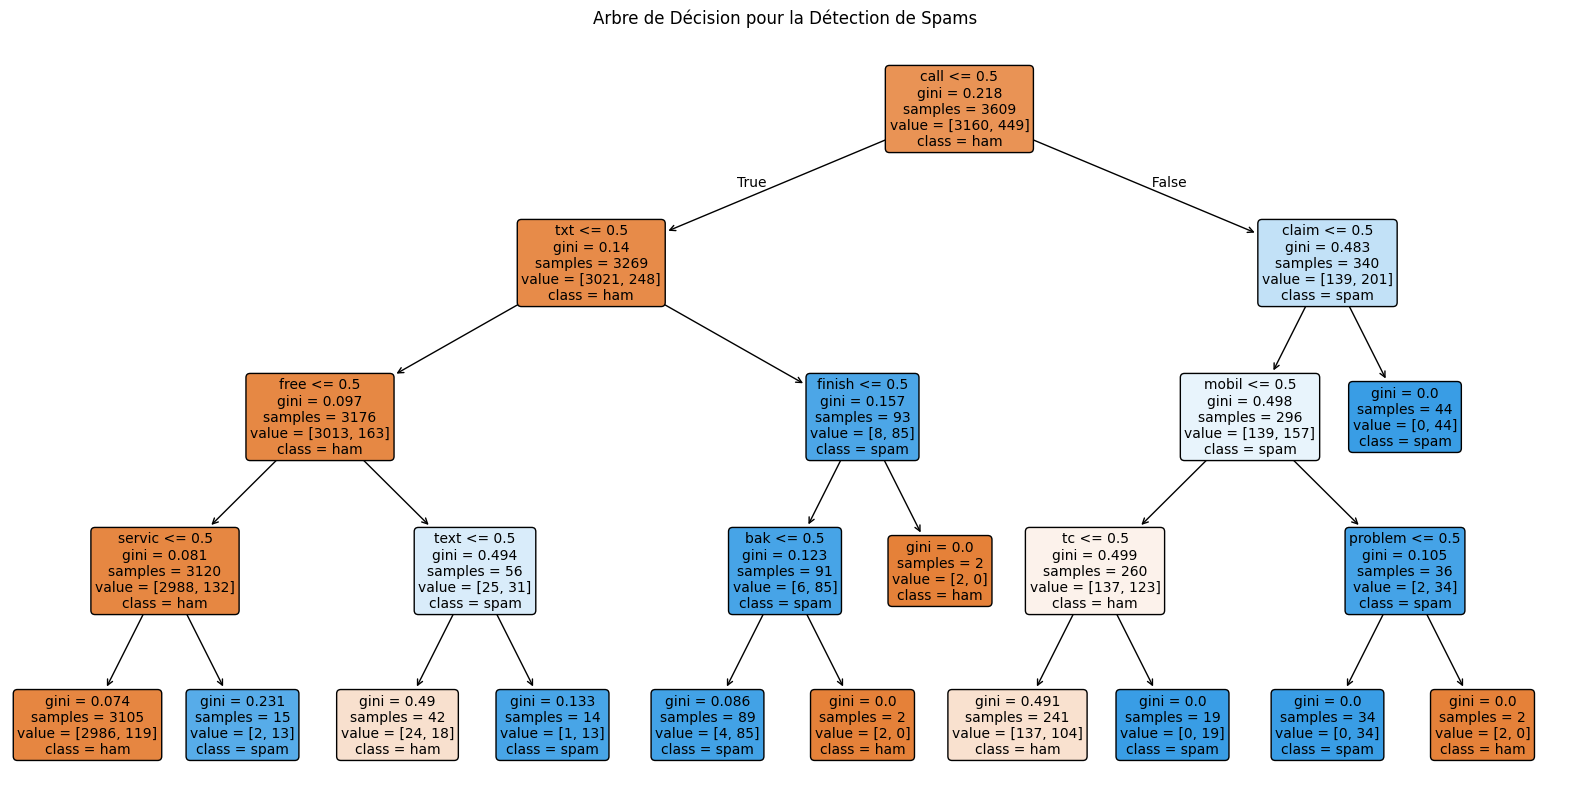

In [290]:
# Création et entraînement de l'arbre de décision
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=4)  # Limite la profondeur de l'arbre
decision_tree.fit(X_Train, Y_Train)

# Affichage de l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=['ham', 'spam'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de Décision pour la Détection de Spams")
plt.show()

## **ML Model training MLPClassifier 1**

### Initialisation des objets MLPClassifier

In [291]:
mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=25, alpha=1e-4,
                    solver= 'sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)


print("MLPClassifier :", MLPClassifier)

multinomialNB : MultinomialNB()
MLPClassifier : <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


In [295]:
X_Resampled.shape

(6320, 2500)

### Entraînement d'un ensemble de données

In [292]:
mlp.fit(X_Resampled, Y_Resampled)

Iteration 1, loss = 0.56667399
Iteration 2, loss = 0.30498218
Iteration 3, loss = 0.21622635
Iteration 4, loss = 0.17715306
Iteration 5, loss = 0.15141934
Iteration 6, loss = 0.13226419
Iteration 7, loss = 0.11734245
Iteration 8, loss = 0.10480140
Iteration 9, loss = 0.09523956
Iteration 10, loss = 0.08720699
Iteration 11, loss = 0.08002106
Iteration 12, loss = 0.07453092
Iteration 13, loss = 0.06980074
Iteration 14, loss = 0.06575531
Iteration 15, loss = 0.06212528
Iteration 16, loss = 0.05943163
Iteration 17, loss = 0.05617144
Iteration 18, loss = 0.05394169
Iteration 19, loss = 0.05178097
Iteration 20, loss = 0.05008195
Iteration 21, loss = 0.04821637
Iteration 22, loss = 0.04694672
Iteration 23, loss = 0.04614786
Iteration 24, loss = 0.04493805
Iteration 25, loss = 0.04379043


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(20,), learning_rate_init=0.1, max_iter=25,
              random_state=1, solver='sgd', verbose=10)

### Génération de la sortie prédite

In [296]:
MLPClassifier_Y_Pred = mlp.predict(X_Test)

print("MLPClassifier_Y_Pred :", MLPClassifier_Y_Pred)

multinomialNB_Y_Pred : [1 0 0 ... 0 0 0]
MLPClassifier_Y_Pred : [1 0 0 ... 0 0 0]


## **ML Model training multinomialNB 1**

### Initialisation des objets multinomialNB

In [313]:
multinomialNB = MultinomialNB()

print("multinomialNB :", multinomialNB)

### Entraînement d'un ensemble de données

In [ ]:
multinomialNB.fit(X_Resampled, Y_Resampled)

### Génération de la sortie prédite

In [ ]:
multinomialNB_Y_Pred = multinomialNB.predict(X_Test)

print("multinomialNB_Y_Pred :", multinomialNB_Y_Pred)

## **ML Model training MultinomialNB 2**


In [297]:
df1.rename(
    columns= {
        'Message': 'sms',
        'Category': 'result'
    },
    inplace=True
)

# Prepare the dataset
X = df1['sms']  # Email content
y = df1['result']  # Spam/Ham labels

# Split into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Text vectorization
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train1)
X_test_vec = vectorizer.transform(X_test1)

# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_vec, y_train1)

# Test the classifier
predictions = model.predict(X_test_vec)

# Evaluate the classifier
accuracy = accuracy_score(y_test1, predictions)
report = classification_report(y_test1, predictions)

accuracy, report


(0.9919282511210762,
 '              precision    recall  f1-score   support\n\n         ham       0.99      1.00      1.00       966\n        spam       1.00      0.94      0.97       149\n\n    accuracy                           0.99      1115\n   macro avg       1.00      0.97      0.98      1115\nweighted avg       0.99      0.99      0.99      1115\n')

## **ML Model training MLPClassifier 2**

In [317]:
# Train a Multi-Layer Perceptron classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_vec, y_train1)

# Test the MLP classifier
mlp_predictions = mlp_model.predict(X_test_vec)

# Evaluate the MLP classifier
mlp_accuracy = accuracy_score(y_test1, mlp_predictions)
mlp_report = classification_report(y_test1, mlp_predictions)

mlp_accuracy, mlp_report

(0.9901345291479821,
 '              precision    recall  f1-score   support\n\n         ham       0.99      1.00      0.99       966\n        spam       1.00      0.93      0.96       149\n\n    accuracy                           0.99      1115\n   macro avg       0.99      0.96      0.98      1115\nweighted avg       0.99      0.99      0.99      1115\n')

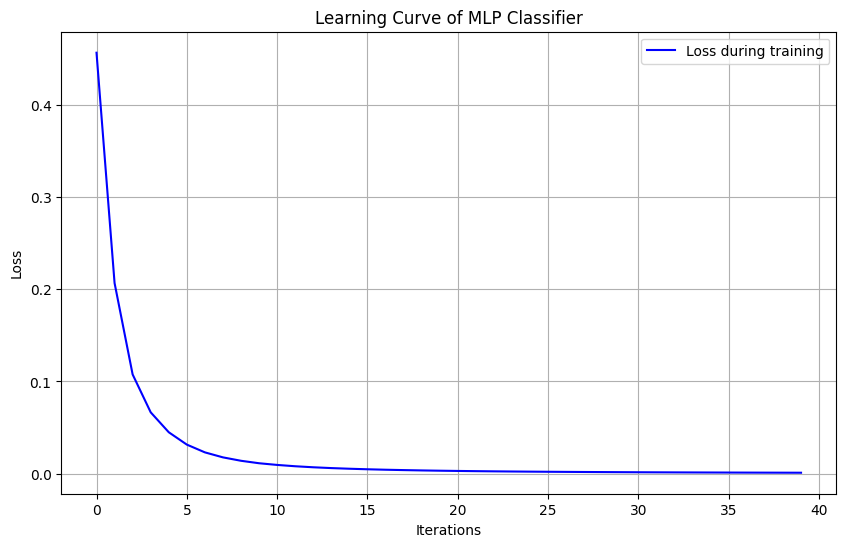

In [318]:
# Get the loss curve from the MLP model
loss_curve = mlp_model.loss_curve_

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(loss_curve, label='Loss during training', color='blue')
plt.title('Learning Curve of MLP Classifier')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## **Mesurer les performances des modèles ML**

### Mesure des Pperformance multinomialNB

In [300]:
multinomialNB_Accuracy = accuracy_score(Y_Test, multinomialNB_Y_Pred)
multinomialNB_Precision = precision_score(Y_Test, multinomialNB_Y_Pred)
multinomialNB_recall_score = recall_score(Y_Test, multinomialNB_Y_Pred)
multinomialNB_f1_score = f1_score(Y_Test, multinomialNB_Y_Pred)


print('multinomialNB accuracy metric:', multinomialNB_Accuracy)
print('multinomialNB precision metric:', multinomialNB_Precision)
print('multinomialNB recall metric:', multinomialNB_recall_score)
print('multinomialNB f1-score metric:', multinomialNB_f1_score)

multinomialNB accuracy metric: 0.9612403100775194
multinomialNB precision metric: 0.8084112149532711
multinomialNB recall metric: 0.9010416666666666
multinomialNB f1-score metric: 0.8522167487684729


### Mesure des performances de MLPClassifier

In [301]:
MLPClassifier_Accuracy = accuracy_score(Y_Test, MLPClassifier_Y_Pred)
MLPClassifier_Precision = precision_score(Y_Test, MLPClassifier_Y_Pred)
MLPClassifier_recall_score = recall_score(Y_Test, MLPClassifier_Y_Pred)
MLPClassifier_f1_score = f1_score(Y_Test, MLPClassifier_Y_Pred)


print('MLPClassifier accuracy metric:', MLPClassifier_Accuracy)
print('MLPClassifier precision metric:', MLPClassifier_Precision)
print('MLPClassifier recall metric:', MLPClassifier_recall_score)
print('MLPClassifier f1-score metric:', MLPClassifier_f1_score)

MLPClassifier accuracy metric: 0.9037467700258398
MLPClassifier precision metric: 0.5776173285198556
MLPClassifier recall metric: 0.8333333333333334
MLPClassifier f1-score metric: 0.6823027718550106


### Courbe d'apprentissage du classificateur MLP Classifier

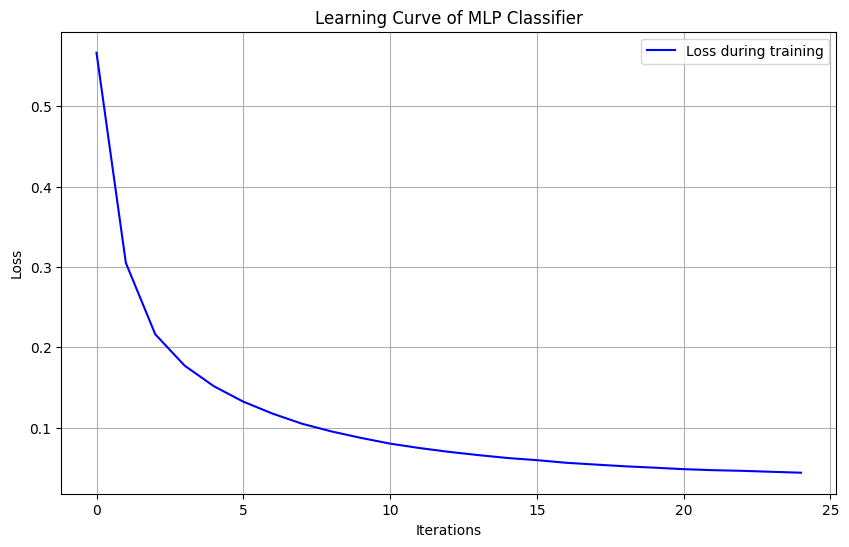

In [302]:
# Get the loss curve from the MLP model
loss_curve = mlp.loss_curve_

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(loss_curve, label='Loss during training', color='blue')
plt.title('Learning Curve of MLP Classifier')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# normalement le labels sont
Y_Test

## **Matrice de confusion**

### matrice de confusion multinomiale NB

Text(0.5, 1.0, 'multinomialNB Confusion Matrix')

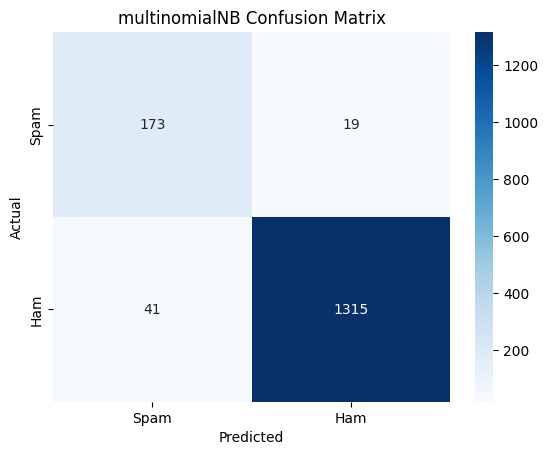

In [303]:
multinomialNB_confussion_matrix = confusion_matrix(Y_Test, multinomialNB_Y_Pred, labels=[1,0])
multinomialNB_Heatmap = sns.heatmap(multinomialNB_confussion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Spam", "Ham"], yticklabels=["Spam", "Ham"])
multinomialNB_Heatmap.set_xlabel('Predicted')
multinomialNB_Heatmap.set_ylabel('Actual')
multinomialNB_Heatmap.set_title('multinomialNB Confusion Matrix')

matrice de confusion MLP Classifier

Text(0.5, 1.0, 'MLP Classifier Confusion Matrix')

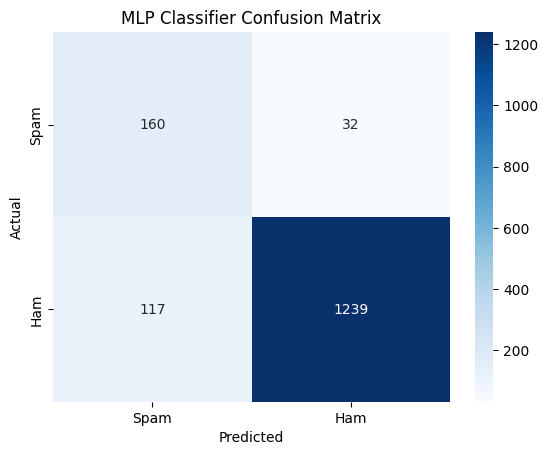

In [320]:
MLPClassifier_confussion_matrix = confusion_matrix(Y_Test, MLPClassifier_Y_Pred, labels=[1,0])
MLPClassifier_Heatmap = sns.heatmap(MLPClassifier_confussion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Spam", "Ham"], yticklabels=["Spam", "Ham"])
MLPClassifier_Heatmap.set_xlabel('Predicted')
MLPClassifier_Heatmap.set_ylabel('Actual')
MLPClassifier_Heatmap.set_title('MLP Classifier Confusion Matrix')

## **TEST**

In [305]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000)),
    ('classifier', MultinomialNB())
])

pipeline.fit(X_train, y_train)
pipeline_predictions = pipeline.predict(X_test)
print("Pipeline Accuracy:", accuracy_score(y_test, pipeline_predictions))


Pipeline Accuracy: 0.9704035874439462


In [306]:
def predict_spam(input_data, pipeline):
    if isinstance(input_data, str):
        input_data = [input_data]
    predictions = pipeline.predict(input_data)
    return predictions

In [308]:
SMS = "Congratulations! You've won a free trip to the Bahamas. Click here to claim."
result = predict_spam(SMS, pipeline)
print("Le Message envoyé est un :", result[0])


Le Message envoyé est un : spam


In [309]:
SMS1 = "are you comming for the party tonight"
result = predict_spam(SMS1, pipeline)
print("Le Message envoyé est un :", result[0])


Le Message envoyé est un : ham


## **Conclusion**

### **explication avec des exemples**



1.   **Stem:**
Le stem (ou radical) est la partie de base d'un mot à laquelle on enlève les suffixes, préfixes ou autres variations. Cela permet de simplifier l’analyse des mots en ramenant leurs formes dérivées à une seule version.

      Exemple :
Mots : "manger", "mangeons", "mangé", "mangeait"
Stem : "mang"

2.   **Vectorisation Encoding**
La vectorisation encoding transforme les données (par exemple, du texte) en une représentation numérique ou vecteur que les algorithmes de machine learning peuvent comprendre.

3.   **One-Hot Encoding:**
Le one-hot encoding est une méthode de transformation des données catégoriques (comme les mots) en vecteurs binaires. Chaque mot ou catégorie est représenté par un vecteur avec une seule valeur "1" et le reste "0".

4.   **Token:**
Un token est une unité de texte divisée dans le cadre de l’analyse de langage. Cela peut être un mot, un caractère ou même un sous-mot, selon la méthode utilisée.




### **Reponse aux Questions :**

1.  **Vaut-il mieux considérer des spams comme des hams ou le contraire ?**

il est mieux de considérer des spams comme des hams (faux négatifs), car cela signifie que quelques spams pourraient apparaître dans la boîte de réception, ce qui est ennuyeux mais facile à corriger en les marquant manuellement comme spam. Cela évite le risque plus grave de classer des hams (emails importants) comme des spams, ce qui pourrait entraîner la perte de messages essentiels et frustrer les utilisateurs.